[Prophet Toolbox Documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

# Import

## Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)
    


Adding C:\Cerebral\_MarioSandBox\Python\covid path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [2]:
import plotly# Complete Database
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Modules

In [3]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis

In [4]:
import pandas as pd
import numpy as np

In [5]:
from utilities.EpiModel import *
import utilities.PDEparams as pde
from scipy.integrate import odeint

In [6]:
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta

# Modeling Functions

In [7]:
def getPop(province='Ontario',p='C:\Cerebral\_MarioSandBox\Python\covid'):
    provinceDataPopFile = '\data\provincePop.csv'
    popData = pd.read_csv(p + provinceDataPopFile)
    popData = popData.set_index('province')    
    return popData.loc[province].population

In [8]:
def seair(X,t,ba,bi,eta,p,g):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]


def seairm(X,t,ba,bi,eta,p,g,m):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i-m*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]

def sol_seair(init,t,ba,bi,eta,p,g):
    sol=odeint(seair,init,t,args=(ba,bi,eta,p,g))
    return(sol)

def sol_seairm(init,t,ba,bi,eta,p,g,m):
    sol=odeint(seairm,init,t,args=(ba,bi,eta,p,g,m))
    return(sol)

In [9]:
def init_s():
    return 1-init_i()

def init_i():
    return df['I'][0]

def init_r():
    return 0

def init_a():
    return 0

def init_e():
    return 0

# Get Data

In [10]:
covidObject = cvd(cached=True)

Getting COVID data
cached


In [11]:
provToAnalyze = 'Ontario'
covidObject.getProcessedData(provToAnalyze)

In [12]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

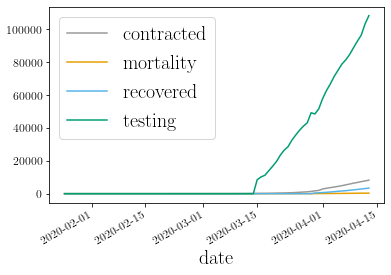

In [13]:
dfData.plot()

In [14]:
dfData.tail()

contracted  mortality  recovered  testing
date                                                 
2020-04-09        6397        233       2305    88698
2020-04-10        6804        269       2574    92673
2020-04-11        7294        290       2858    96321
2020-04-12        7727        303       3121   103165
2020-04-13        8221        333       3357   108230

In [15]:
provPop = getPop('Ontario')

# Trend Analysis

### Contracted

From the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-05 (25)    | 2020-03-20 (40)  |
| 2     | 2020-03-20 (40)    | 2020-04-04 (55)  |
| 3     | 2020-04-04 (55)    | today (:)        |

In [16]:
phase = [1,2,3]
phaseStart = [25,40,55]
phaseEnd = [40,55,len(dfData)]

critPhaseCases = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseCases.append(dictPhase)

### Deaths

Similar to the number of cases graph from the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-18 (38)    | 2020-03-28 (48)  |
| 2     | 2020-03-28 (48)    | 2020-04-06 (57)  |
| 3     | 2020-04-06 (57)    | today (:)        |

In [17]:
phaseStart = [38,48,57]
phaseEnd = [48,57,len(dfData)]

critPhaseDeath = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseDeath.append(dictPhase)

# Modeling SIRM

In [18]:
critPhaseCases

[{'phase': 1, 'phaseStart': 25, 'phaseEnd': 40},
 {'phase': 2, 'phaseStart': 40, 'phaseEnd': 55},
 {'phase': 3, 'phaseStart': 55, 'phaseEnd': 65}]

In [19]:
dfData.tail()

contracted  mortality  recovered  testing
date                                                 
2020-04-09        6397        233       2305    88698
2020-04-10        6804        269       2574    92673
2020-04-11        7294        290       2858    96321
2020-04-12        7727        303       3121   103165
2020-04-13        8221        333       3357   108230

## Estimation

Now analyzing phase 1
       $ba$      $bi$    $eta$       $p$       $g$
0  0.302076  0.658844  0.19939  0.100304  0.071492
error is 9.402870028427893e-13
Now analyzing phase 2
       $ba$     $bi$     $eta$       $p$       $g$
0  0.300276  0.65453  0.199883  0.100973  0.071722
error is 9.718951444091816e-11
Now analyzing phase 3
       $ba$      $bi$     $eta$       $p$       $g$
0  0.301896  0.409392  0.199887  0.100033  0.071465
error is 3.2631279180143376e-09


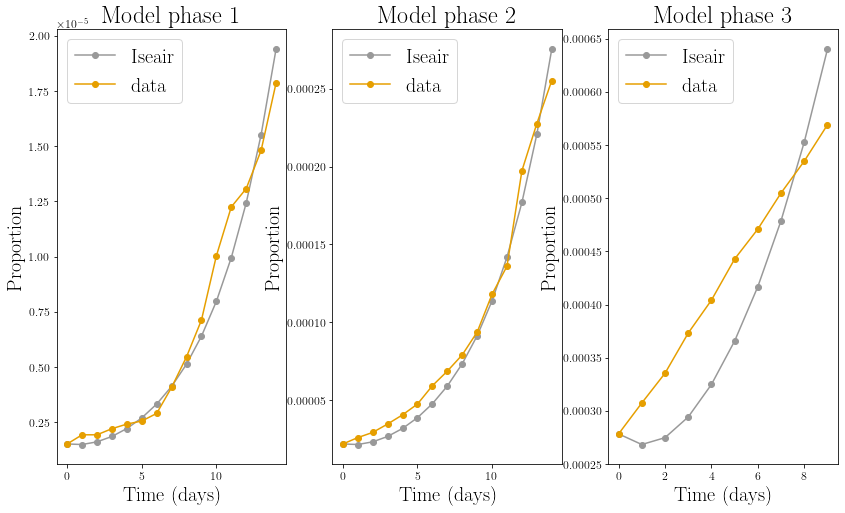

In [20]:
figNum = 1
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for phase in critPhaseCases:
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    #Parameter estimation
    my_seair=pde.PDEmodel(df,
                          seair,
                          [init_s,init_e,init_a,init_i,init_r],
                          bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5)],
                          param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$'], 
                          nvars=5, 
                          ndims=0, 
                          nreplicates=1, 
                          obsidx=[3], 
                          outfunc=None)
    
    
    my_seair.fit()
    my_seair.best_params
    print(f"error is {my_seair.best_error}")
    
    bestPars_seair=my_seair.best_params
    baBseair=bestPars_seair['$ba$'][0]
    biBseair=bestPars_seair['$bi$'][0]
    eBseair=bestPars_seair['$eta$'][0]
    pBseair=bestPars_seair['$p$'][0]
    gBseair=bestPars_seair['$g$'][0]

    bestSol_seair=odeint(seair,
                         [init_s(),init_e(),init_a(),init_i(),init_r()],
                         range(len(iData)),
                         args=(baBseair,biBseair,eBseair,pBseair,gBseair))
    Sseair=bestSol_seair.T[0]
    Eseair=bestSol_seair.T[1]
    Aseair=bestSol_seair.T[2]
    Iseair=bestSol_seair.T[3]
    Rseair=bestSol_seair.T[4]

    
    ax[phase['phase']-1].plot(range(len(iData)),Iseair,'-o',label='Iseair')
    ax[phase['phase']-1].plot(range(len(iData)),df['I'],'-o',label='data')
    ax[phase['phase']-1].set_title(f"Model phase {phase['phase']}")
    ax[phase['phase']-1].set_xlabel('Time (days)')
    ax[phase['phase']-1].set_ylabel('Proportion')
    ax[phase['phase']-1].legend()

I think I am doing something with the E portion of the model as everytime I use it something goes wrong.  Lets look closer in

In [ ]:
figNum = 1
fig1,ax=plt.subplots(1,3,figsize=(14,8))
for phase in critPhaseCases:
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    #Parameter estimation
    my_seairm=pde.PDEmodel(df,
                           seairm,
                           [init_s,init_e,init_a,init_i,init_r],
                           bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                           param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$',r'$m$'], 
                           nvars=5, 
                           ndims=0, 
                           nreplicates=1, 
                           obsidx=[3], 
                           outfunc=None)
   
    my_seairm.fit()
    my_seairm.best_params
    print(f"error is {my_seairm.best_error}")
    bestPars_seairm=my_seairm.best_params
    baBseairm=bestPars_seairm['$ba$'][0]
    biBseairm=bestPars_seairm['$bi$'][0]
    eBseairm=bestPars_seairm['$eta$'][0]
    pBseairm=bestPars_seairm['$p$'][0]
    gBseairm=bestPars_seairm['$g$'][0]
    mBseairm=bestPars_seairm['$m$'][0]

    bestSol_seairm=odeint(seairm,
                          [init_s(),init_e(),init_a(),init_i(),init_r()],
                          range(len(iData)),
                          args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
    #sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
    Sseairm=bestSol_seairm.T[0]
    Eseairm=bestSol_seairm.T[1]
    Aseairm=bestSol_seairm.T[2]
    Iseairm=bestSol_seairm.T[3]
    Rseairm=bestSol_seairm.T[4]
    
    ax[phase['phase']-1].plot(range(len(iData)),Iseairm,'-o',label='Iseairm')
    ax[phase['phase']-1].plot(range(len(iData)),df['I'],'-o',label='data')
    ax[phase['phase']-1].set_title(f"Model phase {phase['phase']}")
    ax[phase['phase']-1].set_xlabel('Time (days)')
    ax[phase['phase']-1].set_ylabel('Proportion')
    ax[phase['phase']-1].legend()

Now analyzing phase 1
       $ba$      $bi$     $eta$       $p$       $g$       $m$
0  0.302305  0.663233  0.199763  0.100406  0.071451  0.002001
error is 9.452979997205213e-13
Now analyzing phase 2
       $ba$      $bi$     $eta$       $p$      $g$      $m$
0  0.300873  0.656973  0.199702  0.100816  0.07145  0.00111
error is 9.761555769139997e-11
Now analyzing phase 3


This looks very similar to the previous one but with a slightly lower error, might use this for prediction but lets coninue with the other models.